In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne import create_info, concatenate_raws,Epochs, find_events
from mne.io import RawArray
import numpy as np
import os
from collections import OrderedDict
import seaborn as sns
import math
from scipy.signal import cheby2

In [3]:
# Get raw data

the_stream = []

sample_fodler = "samples"
participant_id = "00605"
session_id = "S000"
task_id = "T001"

label_id =  {'Non-Target': [90,], 'Target': [0,], 'Distractor':list(range(1,90))}
event_id = {'Non-Target': 1, 'Target': 2, 'Distractor': 3}

prev_label = None
trial_val = 1
sfreq=256
ch_names = []
BP_order = 6
BP_low = .1
BP_hi = 30.
EEG_reject = 70e-6
IMU_reject = 30e-6

eeg_raw = pd.read_csv(os.path.join(sample_fodler,participant_id,f"{participant_id}_{session_id}_{task_id}.csv"))
imu_raw = pd.read_csv(os.path.join(sample_fodler,participant_id,"IMU_B.csv"))
events_raw = pd.read_csv(os.path.join(sample_fodler,participant_id,f"{participant_id}_{session_id}_{task_id}_events.csv"))
impedance_raw = pd.read_csv(os.path.join(sample_fodler,participant_id,"EEG-impedances.csv"))
layout_raw = pd.read_excel(os.path.join(sample_fodler,participant_id,"Layout.xlsx"),index_col=0)

In [36]:
# BP filtering
def BPFiltering(data,l_freq=.1,h_freq=30.,order=6):

    iir_params = dict(order=order, ftype='butter', output='sos')
    filt = data.copy()
    
    print("-> unfiltered PSD")
    filt.plot_psd(fmin=l_freq,fmax=h_freq,average=False)

    filt = filt.filter(l_freq, h_freq, method='iir',iir_params=iir_params)
    print("-> filtered PSD")
    filt.plot_psd(fmin=l_freq,fmax=h_freq,average=False)

    return filt

     timestamp  sequence  battery  flags  IMU_B-ch1  IMU_B-ch2  IMU_B-ch3  \
0  10885421182         0       -2      0   0.000000   0.000000   0.000000   
1  10885431207         1       -2      0  -2.610303  -8.051025  -5.723047   
2  10885476688         2       -2      0  -2.361475  -7.125098  -5.579492   
3  10885486032         3       -2      0  -2.371045  -7.321289  -5.656055   
4  10885558625         4       -2      0  -2.471533  -8.228076  -5.866602   

   IMU_B-ch4  IMU_B-ch5  IMU_B-ch6  IMU_B-ch7   IMU_B-ch8  IMU_B-ch9       sum  
0   0.000000   0.000000   0.000000    0.00000    0.000000   0.000000  0.000000  
1   0.060976   0.304878  -1.189024   92.99814  122.997540 -50.998980  0.000002  
2   3.932927  -0.335366  -2.682927   92.99814  122.997540 -50.998980  0.000005  
3  -2.774390   1.676829  -2.926829   83.99832  116.397672 -61.198776  0.000014  
4  -5.823171   3.414634  -1.920732   83.99832  116.397672 -61.198776  0.000014  


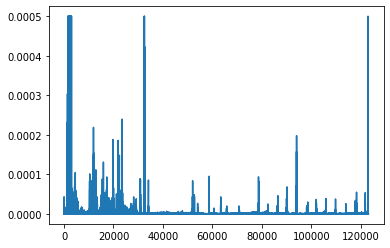

In [5]:
# Get a composite vector of acceleration from IMU

# linear acceleration
imu_acc = imu_raw['IMU_B-ch1'] + imu_raw['IMU_B-ch2'] + imu_raw['IMU_B-ch3']
imu_acc = imu_acc#[1:]
# zero mean unit variance
normalized_imu_acc=(imu_acc[1:]-imu_acc[1:].mean())/imu_acc[1:].std()
# angular acceleration
imu_gyr = imu_raw['IMU_B-ch4'] + imu_raw['IMU_B-ch5'] + imu_raw['IMU_B-ch6']
imu_gyr = imu_gyr#[1:]
# sum both
acc = normalized_imu_acc * imu_gyr
acc = acc.clip(-500, 500).fillna(0.).abs() * 1e-6
acc.plot()
imu_raw['sum'] = acc 
print(imu_raw.head())
#print(imu_raw.tail())

In [6]:
# read imu
# set index
imu_raw = imu_raw.set_index('timestamp')
# create empty eeg_raw column for imu
eeg_raw['Imu'] = pd.Series(dtype='float')

# read events
# create empty eeg_raw column for trials
eeg_raw['Trial'] = pd.Series(dtype='int')
# rename columns
events_raw.columns.values[0] = "sequence"
events_raw.columns.values[1] = "label"
events_raw.columns.values[2] = "trial"
#set index
events_raw = events_raw.set_index('sequence')
# create empty eeg_raw column for stim
eeg_raw['Stim'] = pd.Series(dtype='int')

#events_raw.head()

In [7]:
# add IMU trial index and STIM data to EEG
for index, row in eeg_raw.iterrows():
    # imu data
    imu_index = imu_raw.index.get_loc(row['timestamp'],'ffill')
    imu_val = imu_raw.at[imu_raw.index[imu_index], 'sum']
    eeg_raw.at[index,'Imu'] = imu_val
    
    # stim data
    #event_index = events_raw.index.get_loc(row['sequence'],'ffill')
    #event_val = int(events_raw.at[events_raw.index[event_index], 'label'])
    event_val = events_raw.at[index,'label'] if index in events_raw.index else None
    
    # trial data. starts at 1 and updates when new match is found
    if index in events_raw.index:
        trial_val = events_raw.at[index,'trial']
    eeg_raw.at[index,'Trial'] = trial_val
    
    # check values
    #print(f" - EEG : timestamp:{row['timestamp']} | sequence:{row['sequence']}")
    #print(f" - IMU : timestamp:{imu_raw.index[imu_index]} | imu: {imu_val}")
    #print(f" - EVENT : sequence:{index if index in events_raw.index else None} | stim:  {event_val}")
    #print(f" - TRIAL : trial:{trial_val}")
    
    # assign event ids according to stim labels
    if event_val != prev_label:        
        if event_val in label_id['Non-Target']:
            eeg_raw.at[index,'Stim'] = event_id['Non-Target']
        elif event_val in label_id['Target']:
            eeg_raw.at[index,'Stim'] = event_id['Target']
        elif event_val in label_id['Distractor']:
            eeg_raw.at[index,'Stim'] = event_id['Distractor']
        else:
            eeg_raw.at[index,'Stim'] = 0
        prev_label = event_val
    else:
        eeg_raw.at[index,'Stim'] = 0
#

In [34]:
# convert to mne
ch_names = []
eeg_cols = [col for col in eeg_raw.columns if 'EEG' in col]
# assign channel names according to layout (ommit GND at 0)
for i in range(len(eeg_cols)):
    the_name = layout_raw.index[layout_raw['Channel number'] == i+1].tolist()[0].replace('0','O')#some layouts are mislabelled!!!
    ch_names.append(the_name)
ch_names += ['Imu','Stim']
ch_types = ['eeg']*(len(eeg_cols))+['bio','stim']

the_info = create_info(ch_names=ch_names, ch_types=ch_types,sfreq=sfreq)
the_stream = []
# trial segmentation
trial_num = int(eeg_raw['Trial'].max())
for _tr in range(trial_num):
    # segment raw data by trial flag
    eeg_tr = eeg_raw[eeg_raw['Trial']==_tr+1].copy()
    # remove unnecessary columns
    
    df_mne = eeg_tr.drop(['timestamp', 'sequence', 'battery', 'flags','Trial'], axis=1)
    #print(f"{len(ch_names)}:{ch_names}")
    #print(f"{len(ch_types)}:{ch_types}")
    #print(f"{len(df_mne.columns)}:{df_mne.columns}")
    # transpose data for MNE
    data = df_mne.to_numpy().transpose()
    # scale eeg channels to MIcrovolts and leave IMU and STIM channel intact
    data_mne = np.vstack((data[:-2]*1e-6, data[-2:]))
    # create raw array per trial
    the_stream.append(RawArray(data=data_mne, info=the_info).set_montage( mne.channels.make_standard_montage('standard_1020')))
print(the_stream)

Creating RawArray with float64 data, n_channels=34, n_times=29056
    Range : 0 ... 29055 =      0.000 ...   113.496 secs
Ready.
Creating RawArray with float64 data, n_channels=34, n_times=26112
    Range : 0 ... 26111 =      0.000 ...   101.996 secs
Ready.
Creating RawArray with float64 data, n_channels=34, n_times=26112
    Range : 0 ... 26111 =      0.000 ...   101.996 secs
Ready.
Creating RawArray with float64 data, n_channels=34, n_times=25600
    Range : 0 ... 25599 =      0.000 ...    99.996 secs
Ready.
[<RawArray | 34 x 29056 (113.5 s), ~7.6 MB, data loaded>, <RawArray | 34 x 26112 (102.0 s), ~6.8 MB, data loaded>, <RawArray | 34 x 26112 (102.0 s), ~6.8 MB, data loaded>, <RawArray | 34 x 25600 (100.0 s), ~6.7 MB, data loaded>]


-> evaluating trial 1
<RawArray | 34 x 29056 (113.5 s), ~7.6 MB, data loaded>
-> unfiltered PSD
Effective window size : 8.000 (s)


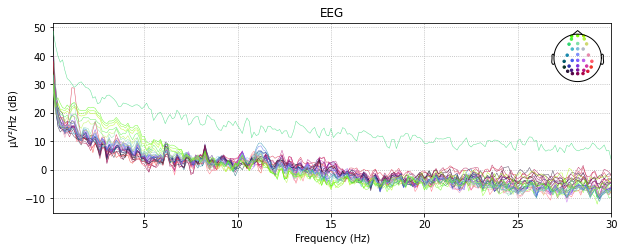

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB

-> filtered PSD
Effective window size : 8.000 (s)


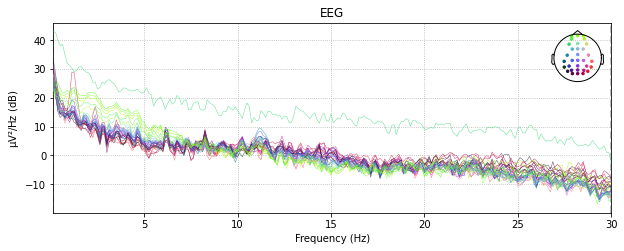

200 events found
Event IDs: [1 2 3]
sample drop %:  99.0
-> evaluating trial 2
<RawArray | 34 x 26112 (102.0 s), ~6.8 MB, data loaded>
-> unfiltered PSD
Effective window size : 8.000 (s)


C:\Users\pierrecu\AppData\Local\Temp/ipykernel_14328/4282458516.py:12: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=9 parameter will result in a sampling frequency of 28.4444 Hz, which can cause aliasing artifacts.
  epochs = Epochs(filtered,


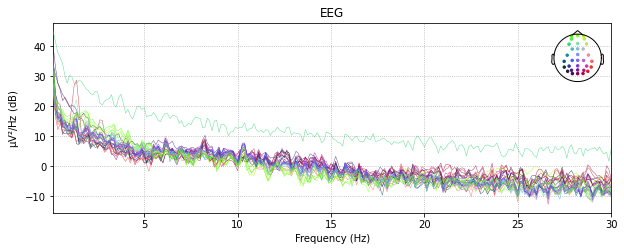

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB

-> filtered PSD
Effective window size : 8.000 (s)


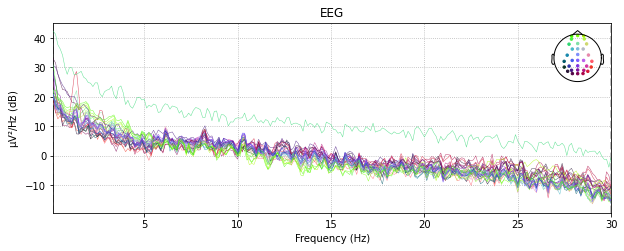

200 events found
Event IDs: [1 2 3]
sample drop %:  99.5
-> evaluating trial 3
<RawArray | 34 x 26112 (102.0 s), ~6.8 MB, data loaded>
-> unfiltered PSD
Effective window size : 8.000 (s)


C:\Users\pierrecu\AppData\Local\Temp/ipykernel_14328/4282458516.py:12: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=9 parameter will result in a sampling frequency of 28.4444 Hz, which can cause aliasing artifacts.
  epochs = Epochs(filtered,


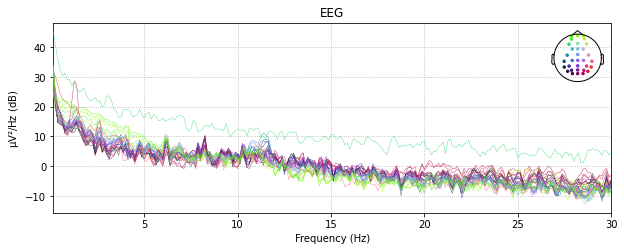

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB

-> filtered PSD
Effective window size : 8.000 (s)


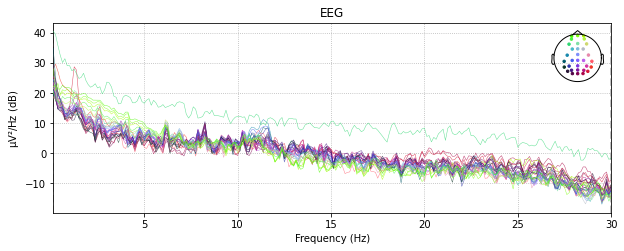

200 events found
Event IDs: [1 2 3]
sample drop %:  96.0
-> evaluating trial 4
<RawArray | 34 x 25600 (100.0 s), ~6.7 MB, data loaded>
-> unfiltered PSD
Effective window size : 8.000 (s)


C:\Users\pierrecu\AppData\Local\Temp/ipykernel_14328/4282458516.py:12: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=9 parameter will result in a sampling frequency of 28.4444 Hz, which can cause aliasing artifacts.
  epochs = Epochs(filtered,


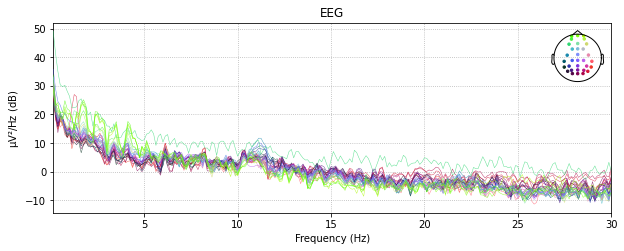

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB

-> filtered PSD
Effective window size : 8.000 (s)


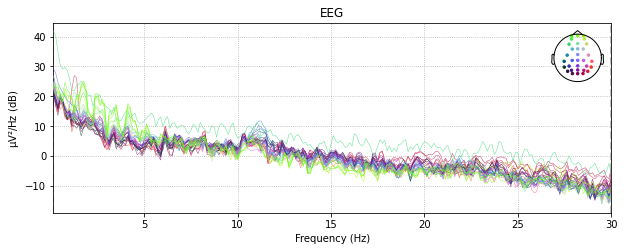

200 events found
Event IDs: [1 2 3]
sample drop %:  55.49999999999999


C:\Users\pierrecu\AppData\Local\Temp/ipykernel_14328/4282458516.py:12: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=9 parameter will result in a sampling frequency of 28.4444 Hz, which can cause aliasing artifacts.
  epochs = Epochs(filtered,


In [37]:
# evaluate each trial data separately
for _i,_tr in enumerate(the_stream):
    print(f"-> evaluating trial {_i+1}")
    print(_tr)
    
    # BP filtering
    filtered = BPFiltering(_tr,l_freq=BP_low,h_freq=BP_hi,order=BP_order)
    
    # find events
    events = find_events(filtered,initial_event=True,stim_channel='Stim')

    # epoch data based on events
    epochs = Epochs(filtered, 
                    events=events, 
                    event_id=event_id,
                    tmin=-0.2, 
                    tmax= 0.8, 
                    baseline=None,
                    decim = np.ceil(sfreq / BP_hi).astype(int), #downsampling epochs
                    reject={'eeg': EEG_reject,'bio': IMU_reject}, #100e-6
                    preload=True,verbose=False, 
                    picks=list(range(len(ch_names)-1)))

    # print the % of dropped samples
    the_drop = (1 - len(epochs.events)/len(events)) * 100
    print('sample drop %: ', the_drop)

In [ ]:
# concatenate all trials
raws = concatenate_raws(the_stream)